# Wall potential (HPMC)

## Overview

### Questions

* How do I apply interactions between **wall geometries** and **particles** in hard particle Monte Carlo simulations?

### Objectives

* Demonstrate the use of the wall potential class.
    
## Boilerplate code

In [1]:
import os

fn = os.path.join(os.getcwd(), 'initial_state.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import math
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([255 / 255, 154 / 255, 202 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]

    geometry.outline_width = 0.08
    fresnel.geometry.Box(scene, [L, L, 0, 0, 0, 0], box_radius=0.08)

    walls = fresnel.geometry.Cylinder(scene, N=4)
    walls.material = fresnel.material.Material(
        color=fresnel.color.linear([90 / 255, 226 / 255, 75 / 255]), roughness=0.5
    )
    walls.outline_width = 0

    box_height = 14
    L = snapshot.configuration.box[0]

    walls.points[:] = [
        [[-L / 2, box_height / 2, 0], [L / 2, box_height / 2, 0]],
        [[-L / 2, -box_height / 2, 0], [L / 2, -box_height / 2, 0]],
        [[-box_height / 2, -L / 2, 0], [-box_height / 2, L / 2, 0]],
        [[box_height / 2, -L / 2, 0], [box_height / 2, L / 2, 0]],
    ]
    walls.radius[:] = 0.04

    scene.lights = [
        fresnel.light.Light(
            direction=(1, 0, 0.4), color=(0.85, 0.85, 0.85), theta=math.pi / 2
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L + 2
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

Place particles in the center of a large simulation box:

In [3]:
import itertools

import gsd.hoomd
import hoomd
import numpy

L = 20
m = 10
N = m**2
x = numpy.linspace(start=-m / 2, stop=m / 2, endpoint=False, num=m) + 1 / 2
position_2d = numpy.array(list(itertools.product(x, repeat=2)))

frame = gsd.hoomd.Frame()
frame.particles.N = N
frame.particles.position = numpy.stack(
    (position_2d[:, 0], position_2d[:, 1], numpy.zeros(N)), axis=-1
)
frame.particles.types = ['mobile']
frame.configuration.box = [L, L, 0, 0, 0, 0]

with gsd.hoomd.open(name='initial_state.gsd', mode='x') as f:
    f.append(frame)

Prepare a hard particle Monte Carlo simulation:

In [4]:
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
simulation.create_state_from_gsd(filename='initial_state.gsd')
simulation.operations.integrator = hoomd.hpmc.integrate.Sphere()
simulation.operations.integrator.shape['mobile'] = dict(diameter=1.0)

## Adding the hard wall potential

Define the same wall surfaces used in the previous section of this tutorial:

In [5]:
top = hoomd.wall.Plane(origin=(0, 7, 0), normal=(0, -1, 0))
bottom = hoomd.wall.Plane(origin=(0, -7, 0), normal=(0, 1, 0))
left = hoomd.wall.Plane(origin=(-7, 0, 0), normal=(1, 0, 0))
right = hoomd.wall.Plane(origin=(7, 0, 0), normal=(-1, 0, 0))

In a Monte Carlo simulation, the integrator accepts or rejects trial moves based on the potential energy of the system. Set the `external_potential` attribute to evaluate the wall potentials during the trial moves:

In [6]:
wall_potential = hoomd.hpmc.external.wall.WallPotential(
    walls=[top, bottom, left, right]
)
simulation.operations.integrator.external_potential = wall_potential

Where MD computes forces between the particle _center_ and the wall surface, the HPMC integrator checks the full extent of each particle's **shape** and sets the energy to infinity whenever any point in the particle's shape has a negative distance to the wall's surface.

Note: HPMC implements shape-wall overlap checks only for certain shape/wall combinations. The documentation for each HPMC shape integrator documents which (if any) wall types it supports.

## Run the simulation

In [7]:
simulation.run(10_000)

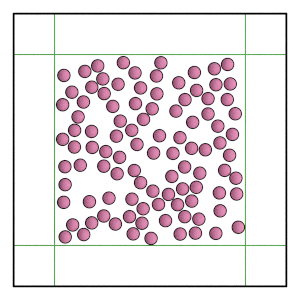

In [8]:
render(simulation.state.get_snapshot())

## Conclusion

This section demonstrates how to apply a hard potential between wall geometries and particles during hard particle Monte Carlo simulations. The previous section showed how to run the same simulation with molecular dynamics.